# Obesity Risk Prediction Model

This notebook builds and trains a Random Forest model to predict obesity risk based on various lifestyle and health factors.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Load and Prepare Data

In [3]:
# Load the dataset
data = pd.read_csv('../data/ObesityDataSet.csv')
data.info();
data.head();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Check for duplicate rows
duplicate_rows = data.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicate_rows)

Missing Values:
 Series([], dtype: int64)

Number of Duplicate Rows: 24


In [5]:
data = data.drop_duplicates()
print("Duplicates removed. New dataset shape:", data.shape)

Duplicates removed. New dataset shape: (2087, 17)


In [6]:
# Split features and target
X = data.drop('NObeyesdad', axis=1)
y = data['NObeyesdad']

# Split numeric and categorical features
numeric_features = X.select_dtypes(exclude=['object']).columns
string_features = X.select_dtypes(include=['object']).columns

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode target variable
label = LabelEncoder()
y_train = label.fit_transform(y_train)
y_test = label.transform(y_test)

In [7]:
# Check unique values in categorical columns (to detect inconsistencies)
categorical_columns = data.select_dtypes(include=['object']).columns
unique_values = {col: data[col].unique() for col in categorical_columns}

print("\nUnique Values in Categorical Columns:")
for col, values in unique_values.items():
    print(f"{col}: {values[:5]}...") 


Unique Values in Categorical Columns:
Gender: ['Female' 'Male']...
family_history_with_overweight: ['yes' 'no']...
FAVC: ['no' 'yes']...
CAEC: ['Sometimes' 'Frequently' 'Always' 'no']...
SMOKE: ['no' 'yes']...
SCC: ['no' 'yes']...
CALC: ['no' 'Sometimes' 'Frequently' 'Always']...
MTRANS: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']...
NObeyesdad: ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight']...


In [8]:
# Check summary statistics for numerical columns (to detect anomalies)
numerical_summary = data.describe()
print("\nNumerical Summary:\n", numerical_summary)


Numerical Summary:
                Age       Height       Weight         FCVC          NCP  \
count  2087.000000  2087.000000  2087.000000  2087.000000  2087.000000   
mean     24.353090     1.702674    86.858730     2.421466     2.701179   
std       6.368801     0.093186    26.190847     0.534737     0.764614   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.915937     1.630178    66.000000     2.000000     2.697467   
50%      22.847618     1.701584    83.101100     2.396265     3.000000   
75%      26.000000     1.769491   108.015907     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2087.000000  2087.000000  2087.000000  
mean      2.004749     1.012812     0.663035  
std       0.608284     0.853475     0.608153  
min       1.000000     0.000000     0.000000  
25%       1.590922     0.124505     0.000000  
50%       2.000000     1.00000

## Data Visualization

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Obesity_Type_I'),
  Text(1, 0, 'Obesity_Type_III'),
  Text(2, 0, 'Obesity_Type_II'),
  Text(3, 0, 'Overweight_Level_II'),
  Text(4, 0, 'Normal_Weight'),
  Text(5, 0, 'Overweight_Level_I'),
  Text(6, 0, 'Insufficient_Weight')])

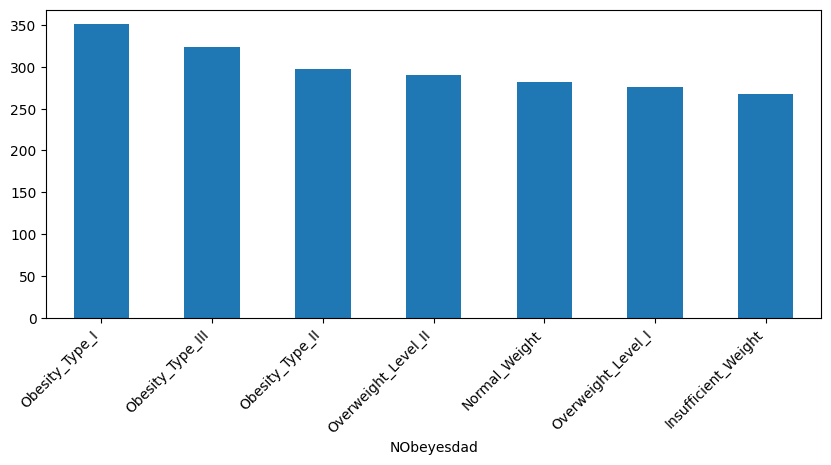

In [9]:
# Target
plt.figure(figsize=(10, 4))
data['NObeyesdad'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')

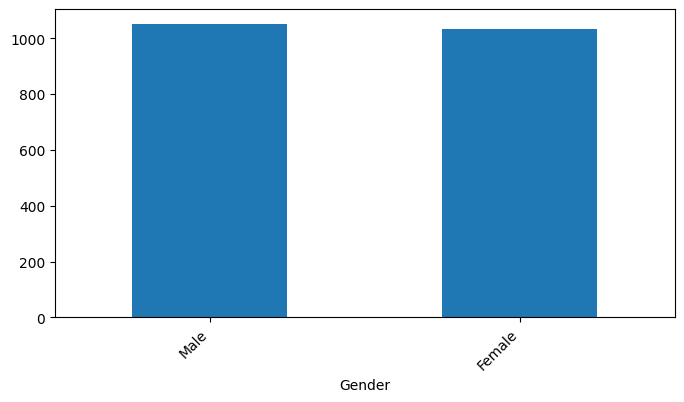

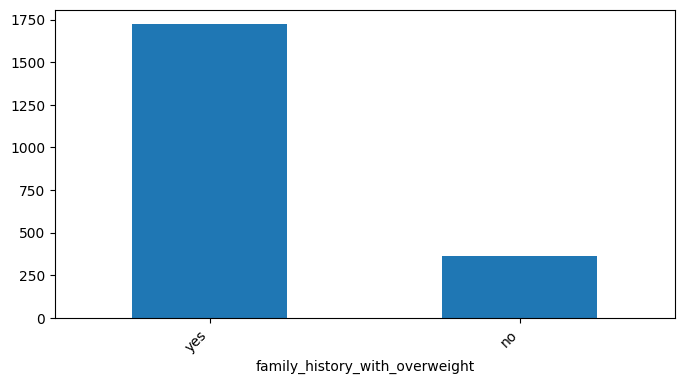

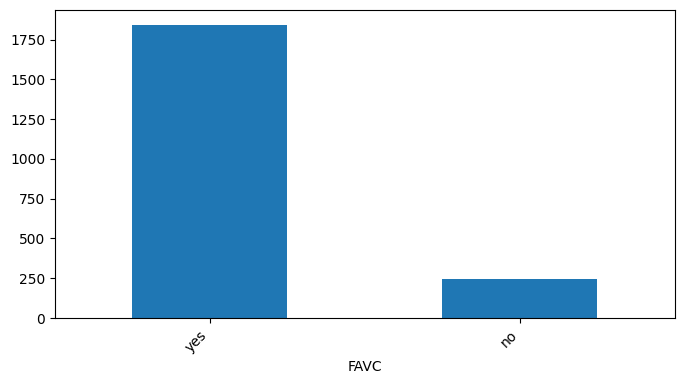

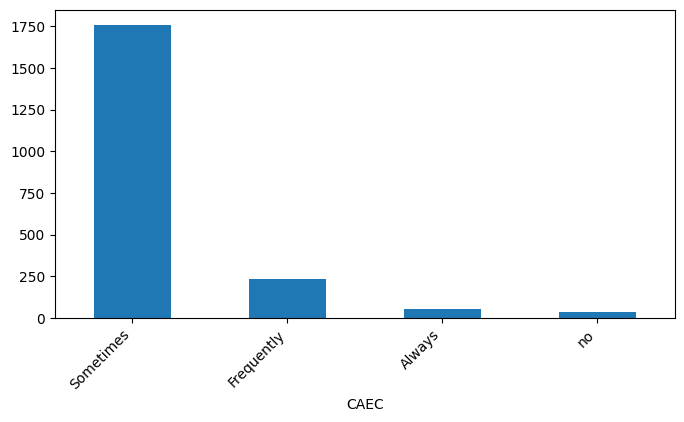

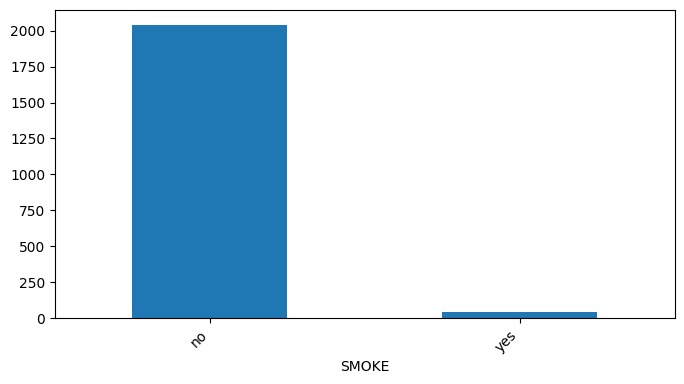

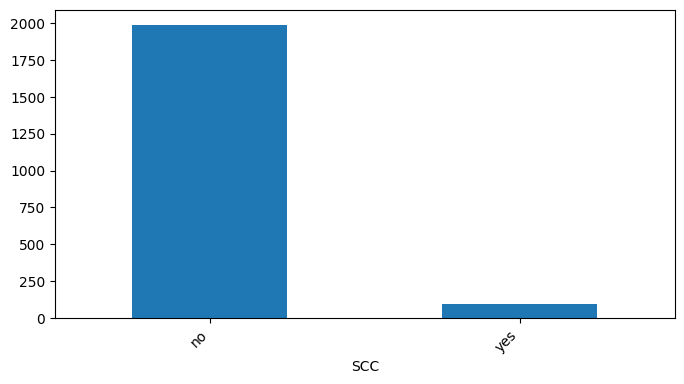

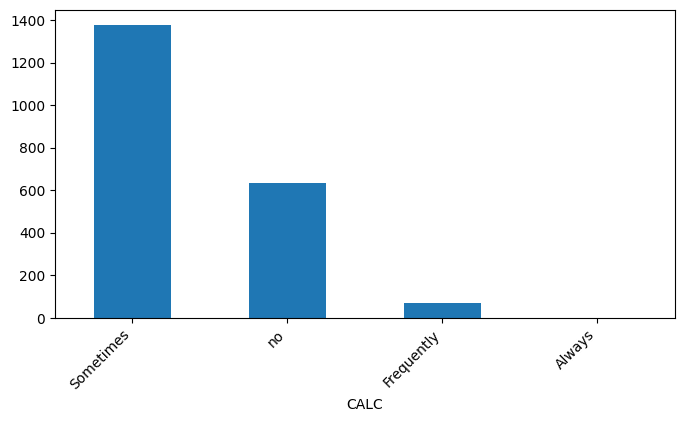

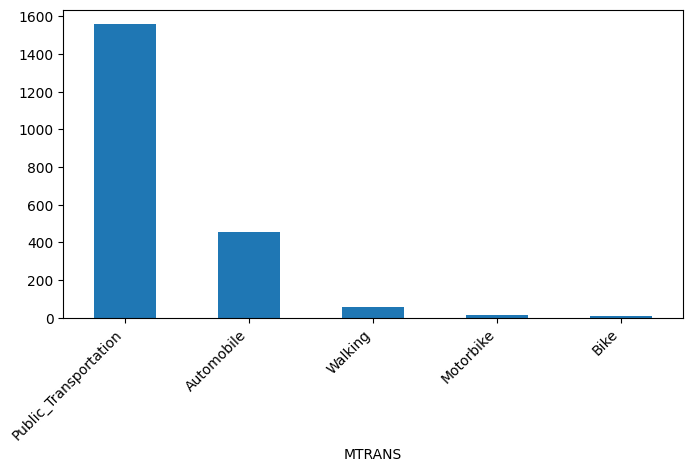

In [10]:
# String features
for col in string_features:

    plt.figure(figsize=(8, 4))
    data[col].value_counts().plot(kind='bar')
    plt.xticks(rotation=45, ha='right')

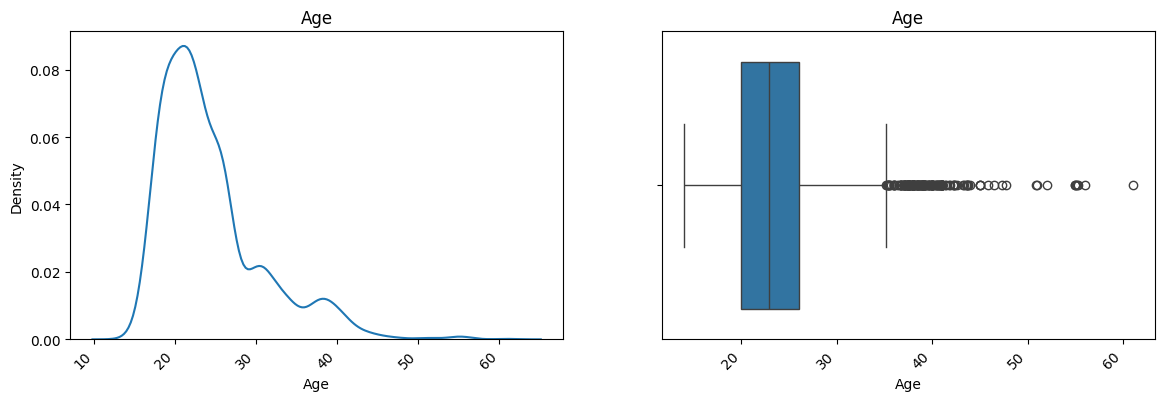

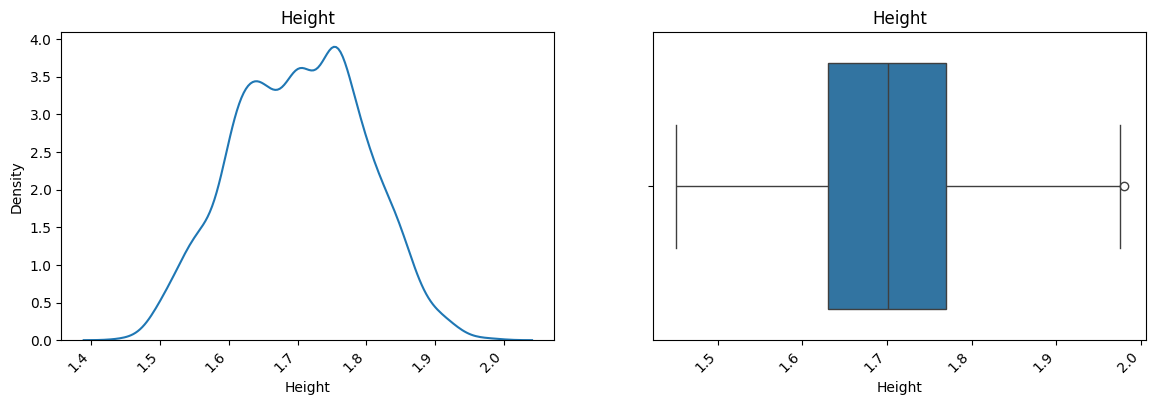

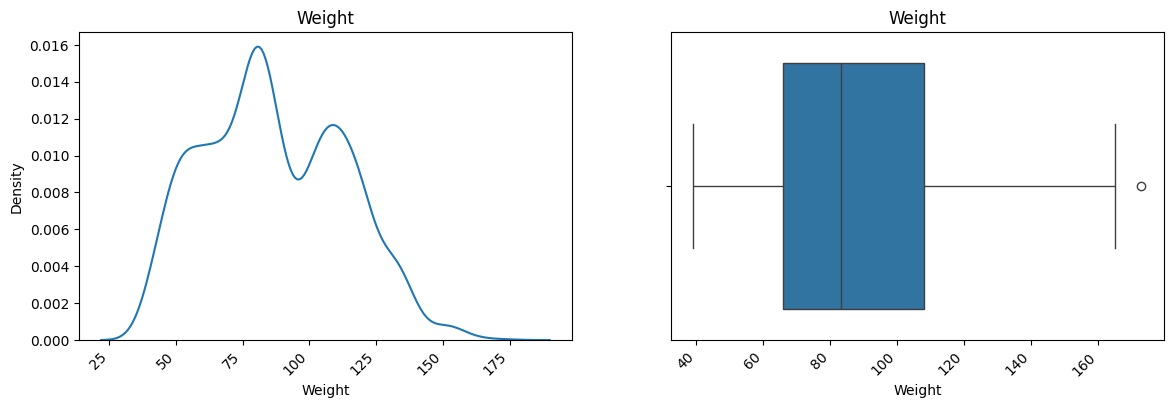

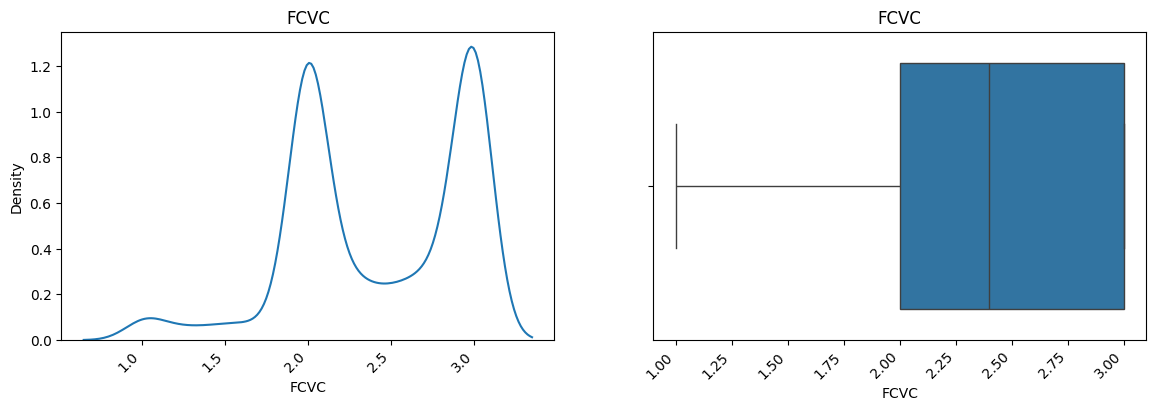

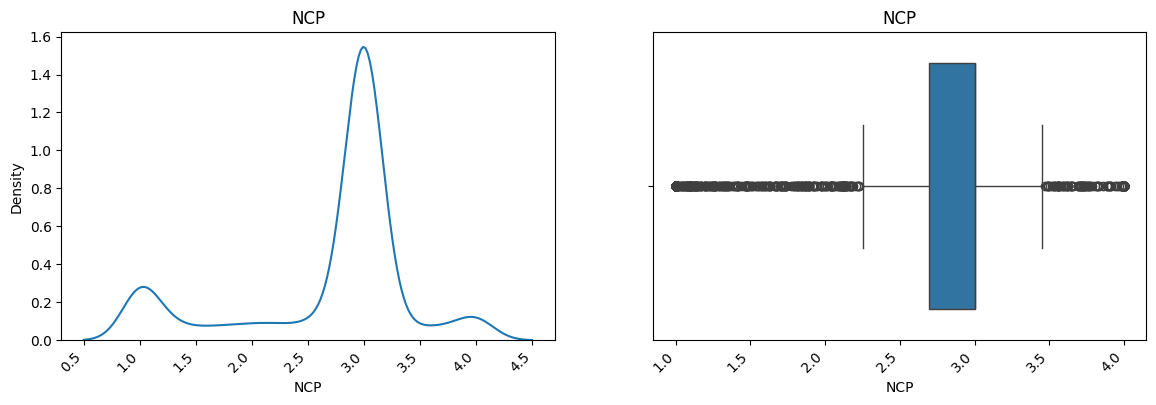

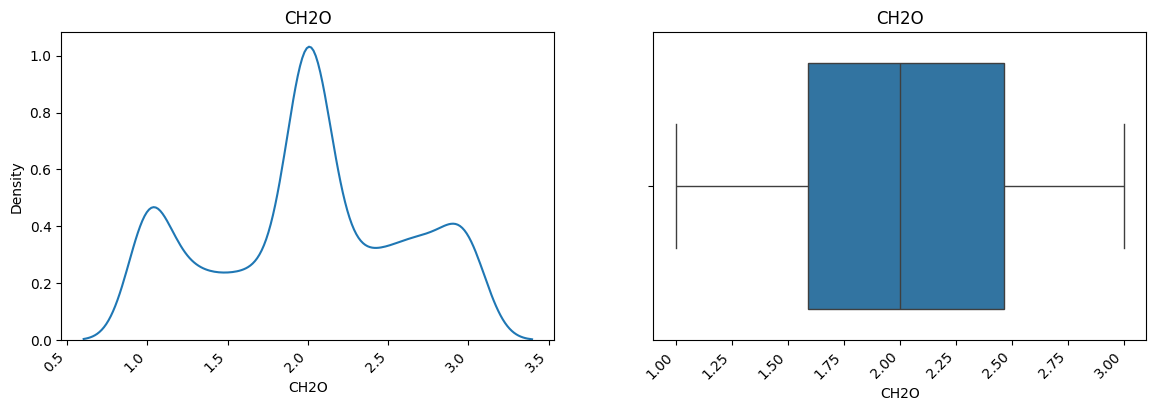

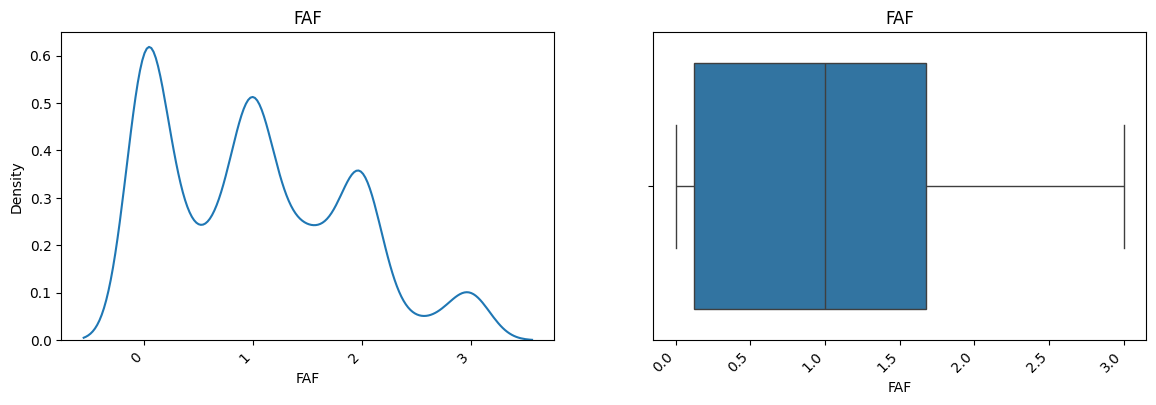

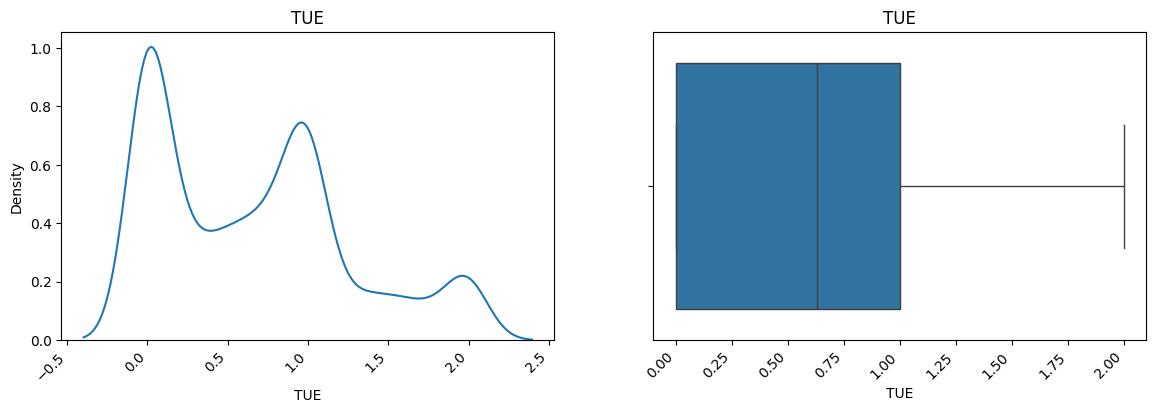

In [11]:
# Numeric features
for col in numeric_features:

    plt.figure(figsize=(14, 4))

    plt.subplot(121)
    sns.kdeplot(data, x=col)
    plt.title(col)
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(122)
    sns.boxplot(data, x=col)
    plt.title(col)
    plt.xticks(rotation=45, ha='right')

## Create Data Preprocessing Pipeline

In [12]:
# Create preprocessing pipelines for numeric and categorical features
string_transformer = Pipeline([
    ('One_Hot_Encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

numeric_transformer = Pipeline([
    ('Power_Transformer', PowerTransformer())
])

# Combine transformers
preprocessor = ColumnTransformer([
    ('numeric_transformer', numeric_transformer, numeric_features),
    ('string_transformer', string_transformer, string_features)
], remainder='passthrough')

## Create and Train Best Model

Using the best hyperparameters found through Optuna optimization:

In [13]:
# Initialize the best model with optimal hyperparameters
best_model = RandomForestClassifier(
    n_estimators=102,
    criterion='log_loss',
    max_depth=11,
    max_features=None,
    min_samples_split=6,
    min_samples_leaf=3,
    max_samples=0.9092488038970724,
    random_state=42
)

# Create pipeline with preprocessor and model
best_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Fit the pipeline
best_pipe.fit(X_train, y_train)

# Make predictions
y_preds = best_pipe.predict(X_test)

## Model Evaluation

In [14]:
# Calculate metrics
print(f"Accuracy: {accuracy_score(y_test, y_preds):.4f}")
print(f"Precision: {precision_score(y_test, y_preds, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_preds, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_preds, average='weighted'):.4f}")

Accuracy: 0.9785
Precision: 0.9789
Recall: 0.9785
F1 Score: 0.9784


## Feature Importance Analysis

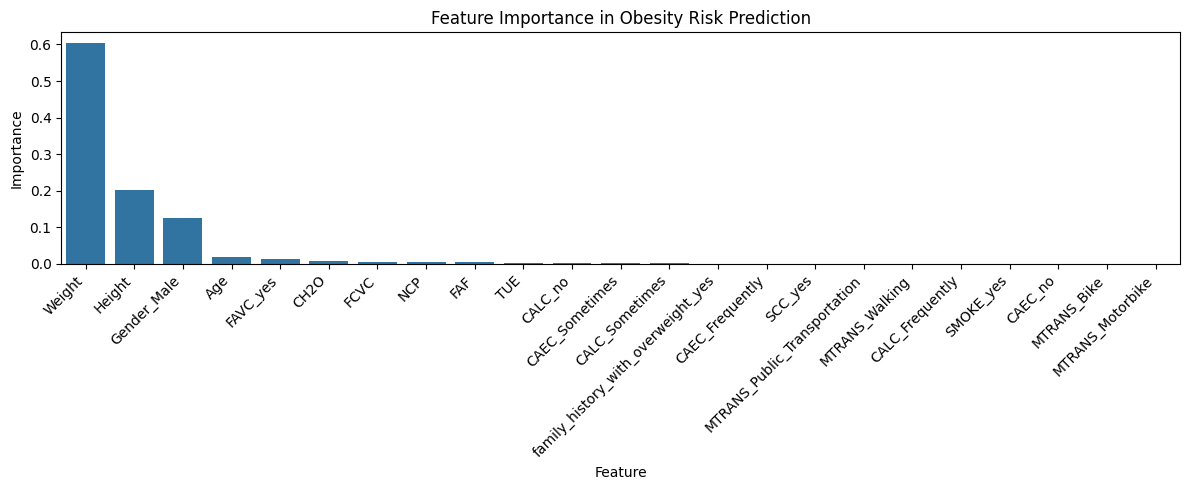

In [15]:
# Get feature names after preprocessing
preprocessor_feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()
feature_names = np.array([s.split('__')[1] for s in preprocessor_feature_names])

# Get feature importances
importances = best_pipe.named_steps['model'].feature_importances_

# Create DataFrame of feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 5))
sns.barplot(data=feature_importances_df, x='Feature', y='Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance in Obesity Risk Prediction')
plt.tight_layout()
plt.show()

## Save the Model

In [16]:
# Save the entire pipeline (including preprocessor and model)
joblib.dump(best_pipe, '../Model/obesity_prediction_model.joblib')

# Save the label encoder for target variable
joblib.dump(label, '../Model/target_encoder.joblib')

print("Model and encoder saved successfully!")

Model and encoder saved successfully!
